In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# 
#  Authored by:    Rasmia Kulan (UKRI-STFC)
#                  Nalin Gupta (UKRI-STFC)
#                  Luke Lozenski (DTU)

# ZeissReader Demo

## Data format: .txrm file

## CIL Version

This notebook was developed using CIL v25.0.0

## Dataset
The data is available from: https://zenodo.org/records/14993402

Update this filepath to where you have saved the dataset:

In [2]:
file_path = '../Data/bin/seed_res2_bin.txrm'

## Loading Geometry

In [3]:
from cil.io import ZEISSDataReader

from cil.utilities.display import show2D, show_geometry

from cil.framework.labels import AcquisitionDimension

In [4]:
reader = ZEISSDataReader(file_name=file_path)

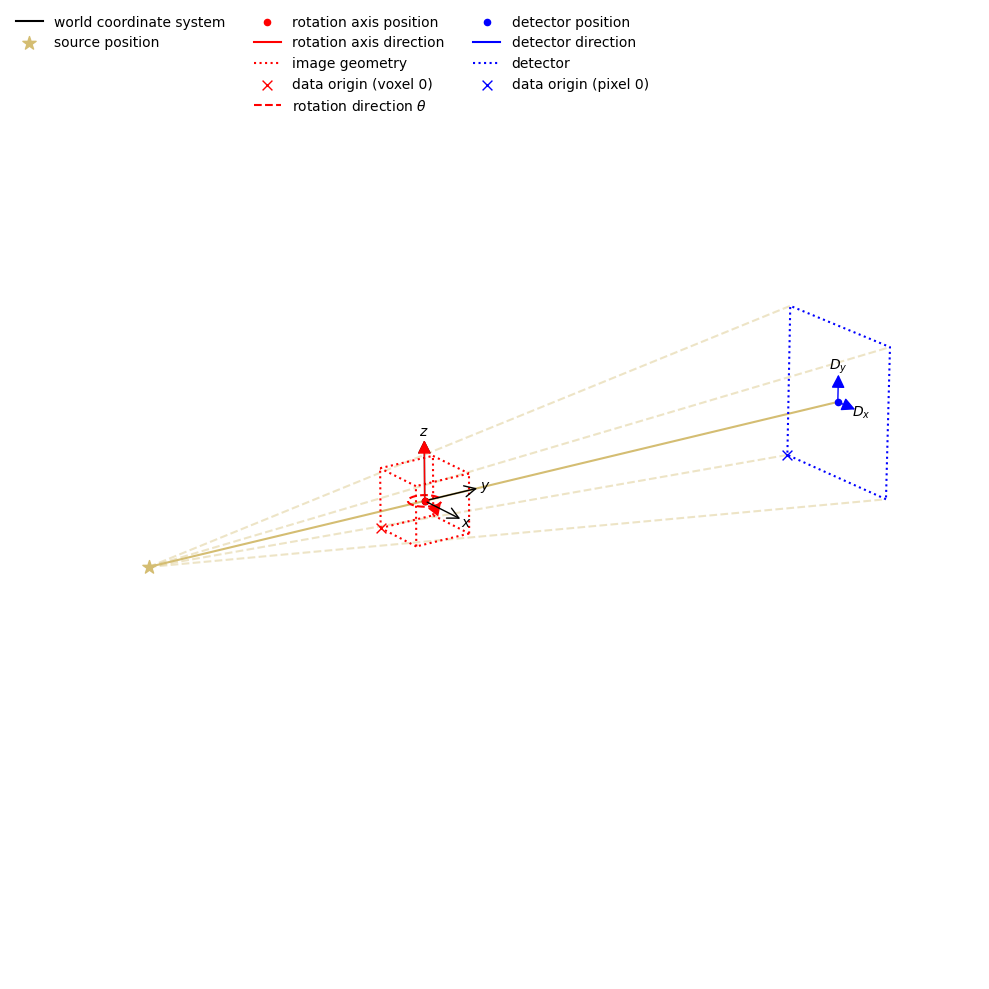

In [5]:
acq_geom = reader.get_geometry()

show_geometry(acq_geom);

In [6]:
print(acq_geom)

3D Cone-beam tomography
System configuration:
	Source position: [  0.       , -13.0246582,   0.       ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 21.25524902,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1013 1013]
	Pixel size: [0.00670058 0.00670058]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1561
	Angles 0-9 in radians: [-3.1415665, -3.1375852, -3.1336646, -3.1295855, -3.1255407, -3.121523 ,
 -3.1175013, -3.1134663, -3.1094341, -3.105374 ]
	Angles 1551-1560 in radians: [3.1052568, 3.1092806, 3.1133163, 3.1173456, 3.1213562, 3.125383 ,
 3.1294239, 3.1334474, 3.1375027, 3.1415982]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


## Loading Projections


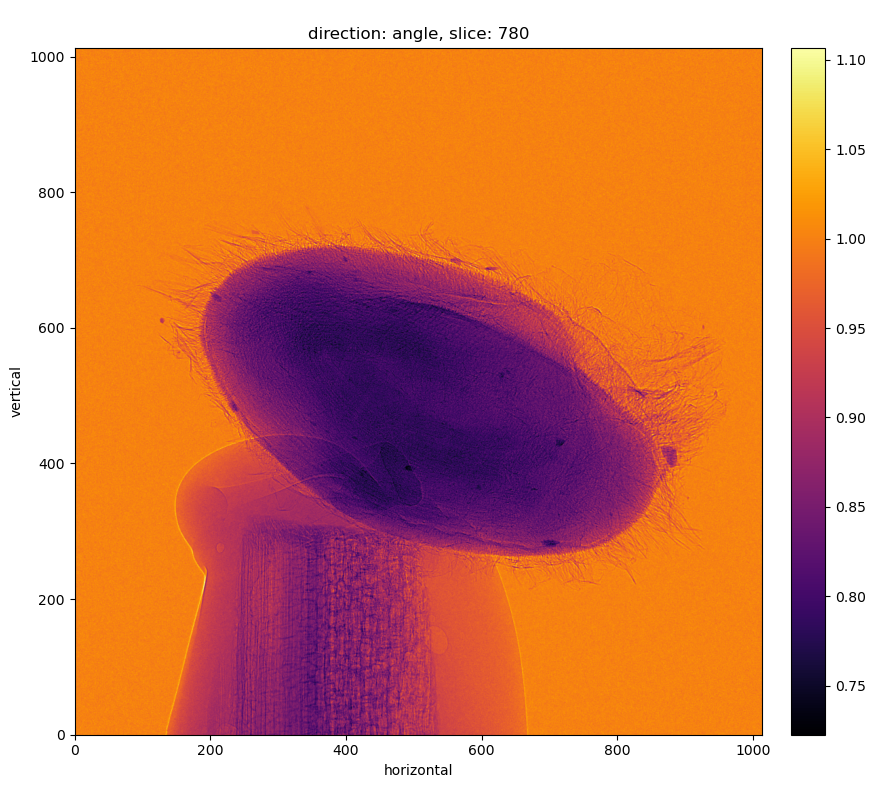

In [7]:
data = reader.read()
data_copy = reader.read()
show2D(data, cmap='inferno');

In [8]:
import numpy as np
#altered the projection angles to correct the projection geometry, ensuring the reconstruction lines up correctly instead of appearing rotated.
data_copy.geometry.set_angles(data.geometry.angles, initial_angle=-45*np.pi/180, angle_unit='radian')

# Pre-processing and Reconstruction

In [9]:
from cil.processors import CentreOfRotationCorrector, TransmissionAbsorptionConverter
from cil.recon import FDK

data_exp = TransmissionAbsorptionConverter()(data, out=data)

data_cor = CentreOfRotationCorrector.image_sharpness(backend="tigre")
data_cor.set_input(data_exp)

corrected_data = data_cor.get_output()

recon = FDK(corrected_data)
recon = recon.run()

FDK recon

Input Data:
	angle: 1561
	vertical: 1013
	horizontal: 1013

Reconstruction Volume:
	vertical: 1013
	horizontal_y: 1013
	horizontal_x: 1013

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



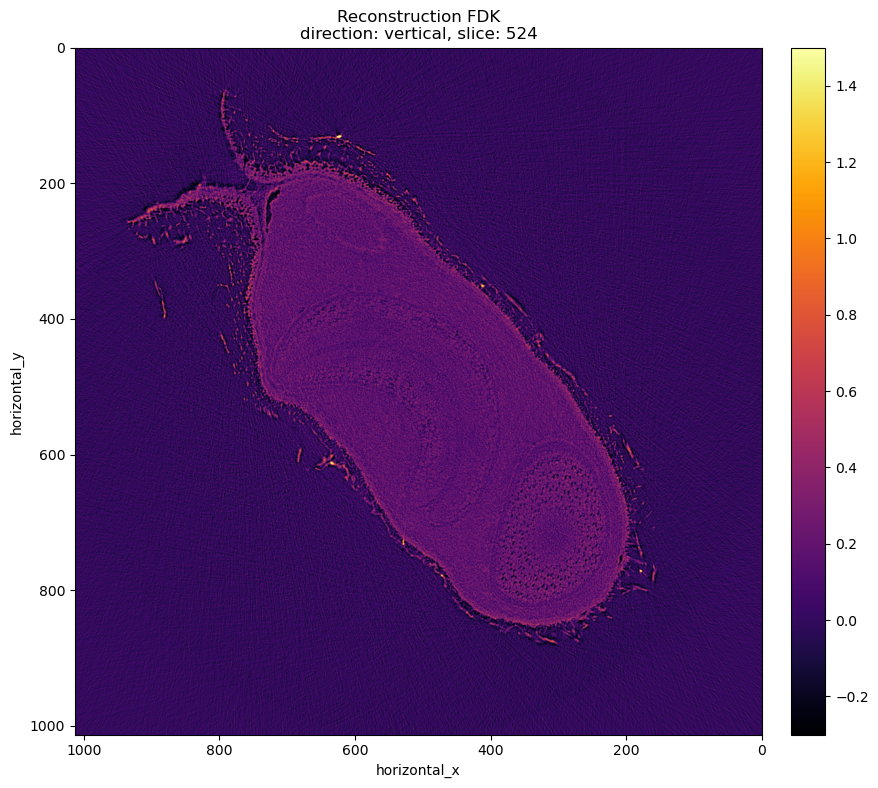

In [10]:
show2D(recon, title='Reconstruction FDK',  origin='upper-right', cmap='inferno', fix_range=(-0.3, 1.5), slice_list=[524]);

In [11]:
data_exp = TransmissionAbsorptionConverter()(data_copy, out=data_copy)

data_cor = CentreOfRotationCorrector.image_sharpness(backend="tigre")
data_cor.set_input(data_exp)

corrected_data = data_cor.get_output()

#defining img geometry and reducing size
ig = corrected_data.geometry.get_ImageGeometry()
ig.voxel_num_y = 500

rotated_recon = FDK(corrected_data, image_geometry=ig)
rotated_recon = rotated_recon.run()

FDK recon

Input Data:
	angle: 1561
	vertical: 1013
	horizontal: 1013

Reconstruction Volume:
	vertical: 1013
	horizontal_y: 500
	horizontal_x: 1013

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



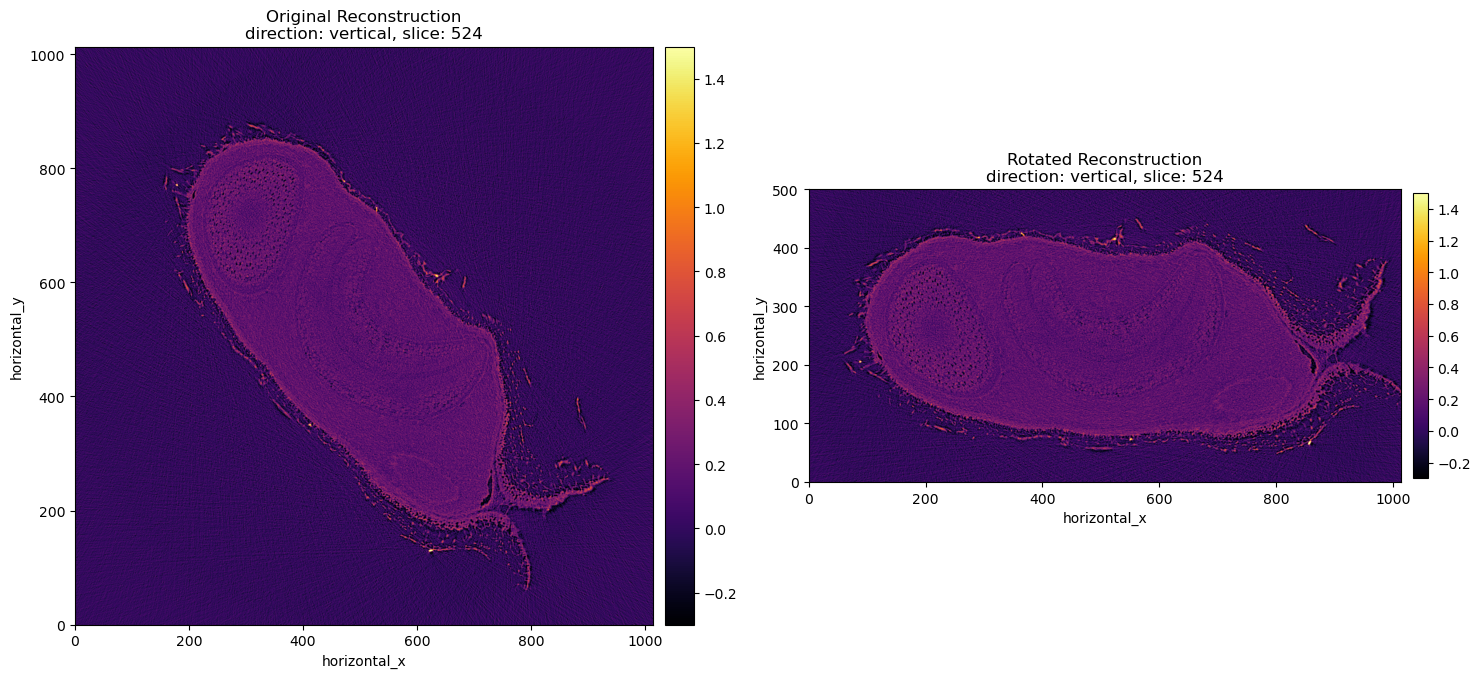

In [14]:
recon_list = [recon, rotated_recon]
recon_labels = ['Original Reconstruction', 'Rotated Reconstruction']
show2D(recon_list, title=recon_labels, cmap='inferno', num_cols=2, fix_range=(-0.3, 1.5), slice_list=[524,524])